In [36]:
import numpy as np 
from tqdm import tqdm 
import pandas as pd
import itertools
from xlnet_plabel_utils import GWSDatasetFromPandas 
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from permetrics.regression import RegressionMetric

In [ ]:
# global variables
# global variables
nt_list = ['A', 'C', 'G', 'T']
codon_list = [''.join(codon) for codon in itertools.product(nt_list, repeat=3)]

stop_codons = ['TAA', 'TAG', 'TGA']

# remove stop codons from the dictionary
for codon in stop_codons:
    codon_list.remove(codon)

# create a dictionary of codons
codon_to_id = {v:k for k,v in enumerate(codon_list)}
id_to_codon = {k:v for k,v in enumerate(codon_list)}

codonid_list = list(id_to_codon.keys())

print('Number of codons:', len(codonid_list))

condition_dict_values = {64: 'CTRL', 65: 'ILE', 66: 'LEU', 67: 'LEU_ILE', 68: 'LEU_ILE_VAL', 69: 'VAL'}
condition_dict = {v: k for k, v in condition_dict_values.items()}

In [ ]:
mutations_everything = np.load('bms/mutations_everything_100.npz', allow_pickle=True)

In [ ]:
mutations_everything = mutations_everything['mutations_everything'].item()

In [ ]:
mutations_everything.keys()

In [ ]:
keys = list(mutations_everything.keys())
print(mutations_everything[keys[0]])

In [37]:
motif_str = []
motif_len = []
condition = []
perc_increase = []
orig_density_list = []
new_density_list = []

In [38]:
for k in tqdm(keys):
    # print(k)
    start = k[2]
    orig_density = k[5]
    # print(mutations_everything[k])
    for mo in mutations_everything[k]:
        # print(mo, len(mo))
        condition.append(k[4])
        new_density = mutations_everything[k][mo]
        orig_density_list.append(orig_density)
        new_density_list.append(new_density)
        # print(orig_density, new_density, (new_density-orig_density)/orig_density)
        try:
            perc_increase.append(np.abs((new_density-orig_density)/orig_density))
        except:
            perc_increase.append(0)
        # print(orig_density, new_density)
        motif_len.append(int(len(mo)/2))
        motif_sample_dict = {}
        for i in range(0, len(mo), 2):
            # print(start-mo[i], mo[i+1])
            motif_sample_dict[mo[i] - (start+10)] = mo[i+1]
        # sort the dictionary in ascending order of the keys
        motif_sample_dict = dict(sorted(motif_sample_dict.items()))
        motif_str_sample = ''
        # print(motif_sample_dict)
        for k1, v1 in motif_sample_dict.items():
            motif_str_sample += str(k1) + '_' + str(v1) + '_'
        # print(motif_str_sample)
        motif_str.append(motif_str_sample)

100%|██████████| 600/600 [00:00<00:00, 685.00it/s]


In [39]:
# make a dataframe
df = pd.DataFrame({'motif': motif_str, 'motif_len': motif_len, 'perc_increase': perc_increase, 'condition': condition, 'orig_density': orig_density_list, 'new_density': new_density_list})

In [40]:
df

,motif,motif_len,perc_increase,condition,orig_density,new_density
0,3_59_,1,1.154614,CTRL,0.354478,0.763764
1,3_58_,1,1.110725,CTRL,0.354478,0.748206
2,3_56_,1,1.081292,CTRL,0.354478,0.737773
3,3_11_,1,1.075891,CTRL,0.354478,0.735858
4,3_51_,1,1.034526,CTRL,0.354478,0.721195
...,...,...,...,...,...,...
92995,-4_54_-2_52_-1_54_,3,11.683052,VAL,-0.047110,0.503278
92996,-4_54_-2_52_-1_53_,3,10.993657,VAL,-0.047110,0.470801
92997,-4_54_-3_54_-2_52_,3,10.962031,VAL,-0.047110,0.469311
92998,-5_14_-4_54_-2_52_,3,10.325638,VAL,-0.047110,0.439331


In [ ]:
pos = []
for i in range(len(motif_str)):
    x = motif_str[i].split('_')[:-1]
    x = [int(el) for el in x]
    for j in range(0, len(x), 2):
        pos.append(x[j])

In [ ]:
np.unique(pos)

In [ ]:
df['condition'].unique()

In [ ]:
# generate peak windows, and all windows
# convert pandas dataframes into torch datasets
test_dataset = pd.read_csv('../../../data/orig/val_0.3_NZ_20_PercNan_0.05.csv')
train_dataset = pd.read_csv('../../../data/orig/train_0.3_NZ_20_PercNan_0.05.csv')
val_dataset = pd.read_csv('../../../data/orig/test_0.3_NZ_20_PercNan_0.05.csv')

# merge the datasets
merged_dataset = pd.concat([train_dataset, val_dataset], ignore_index=True)

# create the datasets
merged_dataset = GWSDatasetFromPandas(merged_dataset)

print("samples in merged dataset: ", len(merged_dataset))

In [ ]:
motifs_final_dfs = {}
motifs_final = {}
for c in df['condition'].unique():
    print(c)

    # put them in descending order
    df_1 = df[(df['motif_len'] == 1) & (df['condition'] == c)]['motif'].value_counts().sort_values(ascending=False)[:10]
    df_2 = df[(df['motif_len'] == 2) & (df['condition'] == c)]['motif'].value_counts().sort_values(ascending=False)[:10]
    df_3 = df[(df['motif_len'] == 3) & (df['condition'] == c)]['motif'].value_counts().sort_values(ascending=False)[:10]

    motifs_final_dfs[c] = {'1': df_1, '2': df_2, '3': df_3}
    motifs_final[c] = df_1.index.tolist() + df_2.index.tolist() + df_3.index.tolist()
    # convert to dict with two counts for each motif
    motifs_final[c] = {m: (0, 0) for m in motifs_final[c]} # peaks, all (counts)

In [ ]:
def motifCheck(motif, window):
    motif = [int(x) for x in motif.split('_')[:-1]]
    
    # print(motif_len, motif, window)
    for b in range(0, len(motif), 2):
        try:
            if window[motif[b]+10] != motif[b+1]:
                # print('False')
                return False
        except:
            print('Error:', motif, window)
    # print('True')
    return True
    

In [ ]:
window_size = 16
num_peaks_windows = 0
num_all_windows = 0
for i in tqdm(range(len(merged_dataset))):
    sample_condition = condition_dict_values[merged_dataset[i][0][0].item()]
    y_true_sample = merged_dataset[i][1].numpy()
    x_input_sample = merged_dataset[i][0].numpy()
    if len(y_true_sample) > 500:
        continue 
    peak_thresh = np.nanmean(y_true_sample) + np.nanstd(y_true_sample)
    for j in range(1, len(y_true_sample)):
        window = x_input_sample[j:j+window_size]
        if len(window) == window_size:
            if y_true_sample[j+10] > peak_thresh:
                num_peaks_windows += 1
                num_all_windows += 1
                for m in motifs_final[sample_condition]:
                    if motifCheck(m, window):
                        motifs_final[sample_condition][m] = (motifs_final[sample_condition][m][0]+1, motifs_final[sample_condition][m][1]+1)
            else:
                num_all_windows += 1
                for m in motifs_final[sample_condition]:
                    if motifCheck(m, window):
                        motifs_final[sample_condition][m] = (motifs_final[sample_condition][m][0], motifs_final[sample_condition][m][1]+1)

In [ ]:
motifs_final_p = {'CTRL': {}, 'ILE': {}, 'LEU': {}, 'LEU_ILE': {}, 'LEU_ILE_VAL': {}, 'VAL': {}}
for c in motifs_final:
    # print(c)
    for m in motifs_final[c]:
        # print(m, motifs_final[c][m])
        # print(motifs_final[c][m][0], num_peaks_windows-motifs_final[c][m][0], motifs_final[c][m][1], num_all_windows-motifs_final[c][m][1]-motifs_final[c][m][0])
        try:
            obs = np.array([[motifs_final[c][m][0], num_peaks_windows-motifs_final[c][m][0]], [motifs_final[c][m][1], num_all_windows-motifs_final[c][m][1]-motifs_final[c][m][0]]])
            chi2, p, dof, expected = chi2_contingency(obs, correction=True)
        except:
            if motifs_final[c][m][1] == 0:
                p = '-'
        
        motifs_final_p[c][m] = (motifs_final[c][m][0], motifs_final[c][m][1], p)

In [48]:
def getPercIncrease(motif, condition):
    # print(motif, condition)
    x = df[(df['motif'] == motif) & (df['condition'] == condition)]['perc_increase']
    if len(x) == 0:
        return 0
    else:
        # return the mean value
        return x.mean()
    
def getFreqPerc(motif, condition):
    x = df[(df['motif'] == motif) & (df['condition'] == condition)]
    motif_len = len(motif.split('_')) // 2
    x_len = df[(df['motif_len'] == motif_len) & (df['condition'] == condition)]
    return len(x) / len(x_len)

def getMAAPE(motif, condition):
    orig_density_lis = list(df[(df['motif'] == motif) & (df['condition'] == condition)]['orig_density'])
    new_density_lis = list(df[(df['motif'] == motif) & (df['condition'] == condition)]['new_density'])

    evaluator = RegressionMetric(new_density_lis, orig_density_lis)
    return np.abs(evaluator.mean_arctangent_absolute_percentage_error())

[0.2976817488670349, 0.42161864042282104, 0.23792129755020142, 0.5498325824737549, 0.3691115975379944, 0.2410033494234085, 0.371398389339447, 0.14135509729385376, 0.4471476972103119, 0.29523032903671265, 0.5581148862838745, 0.3775130808353424, 0.4229746460914612, 0.47681668400764465, 0.6559538245201111, 0.3391209542751312, 0.09879612922668457, 0.03900919854640961, 0.2443222999572754, 0.13937462866306305, 0.28588688373565674, 0.6950439214706421, 0.36899232864379883] [0.7071020603179932, 0.903201699256897, 0.765070915222168, 0.8093137741088867, 0.7986663579940796, 0.5009707808494568, 0.5310013294219971, 0.3900323212146759, 1.1326333284378052, 0.5864249467849731, 2.077040195465088, 0.8284504413604736, 0.6549175977706909, 1.0247026681900024, 1.1472138166427612, 0.5723281502723694, 0.38787537813186646, 0.5733712315559387, 0.48028865456581116, 0.4325329661369324, 0.521774411201477, 0.8827842473983765, 0.5481193661689758]
0.4743869383187369
[0.5498325824737549, 0.26034265756607056, 0.14135509

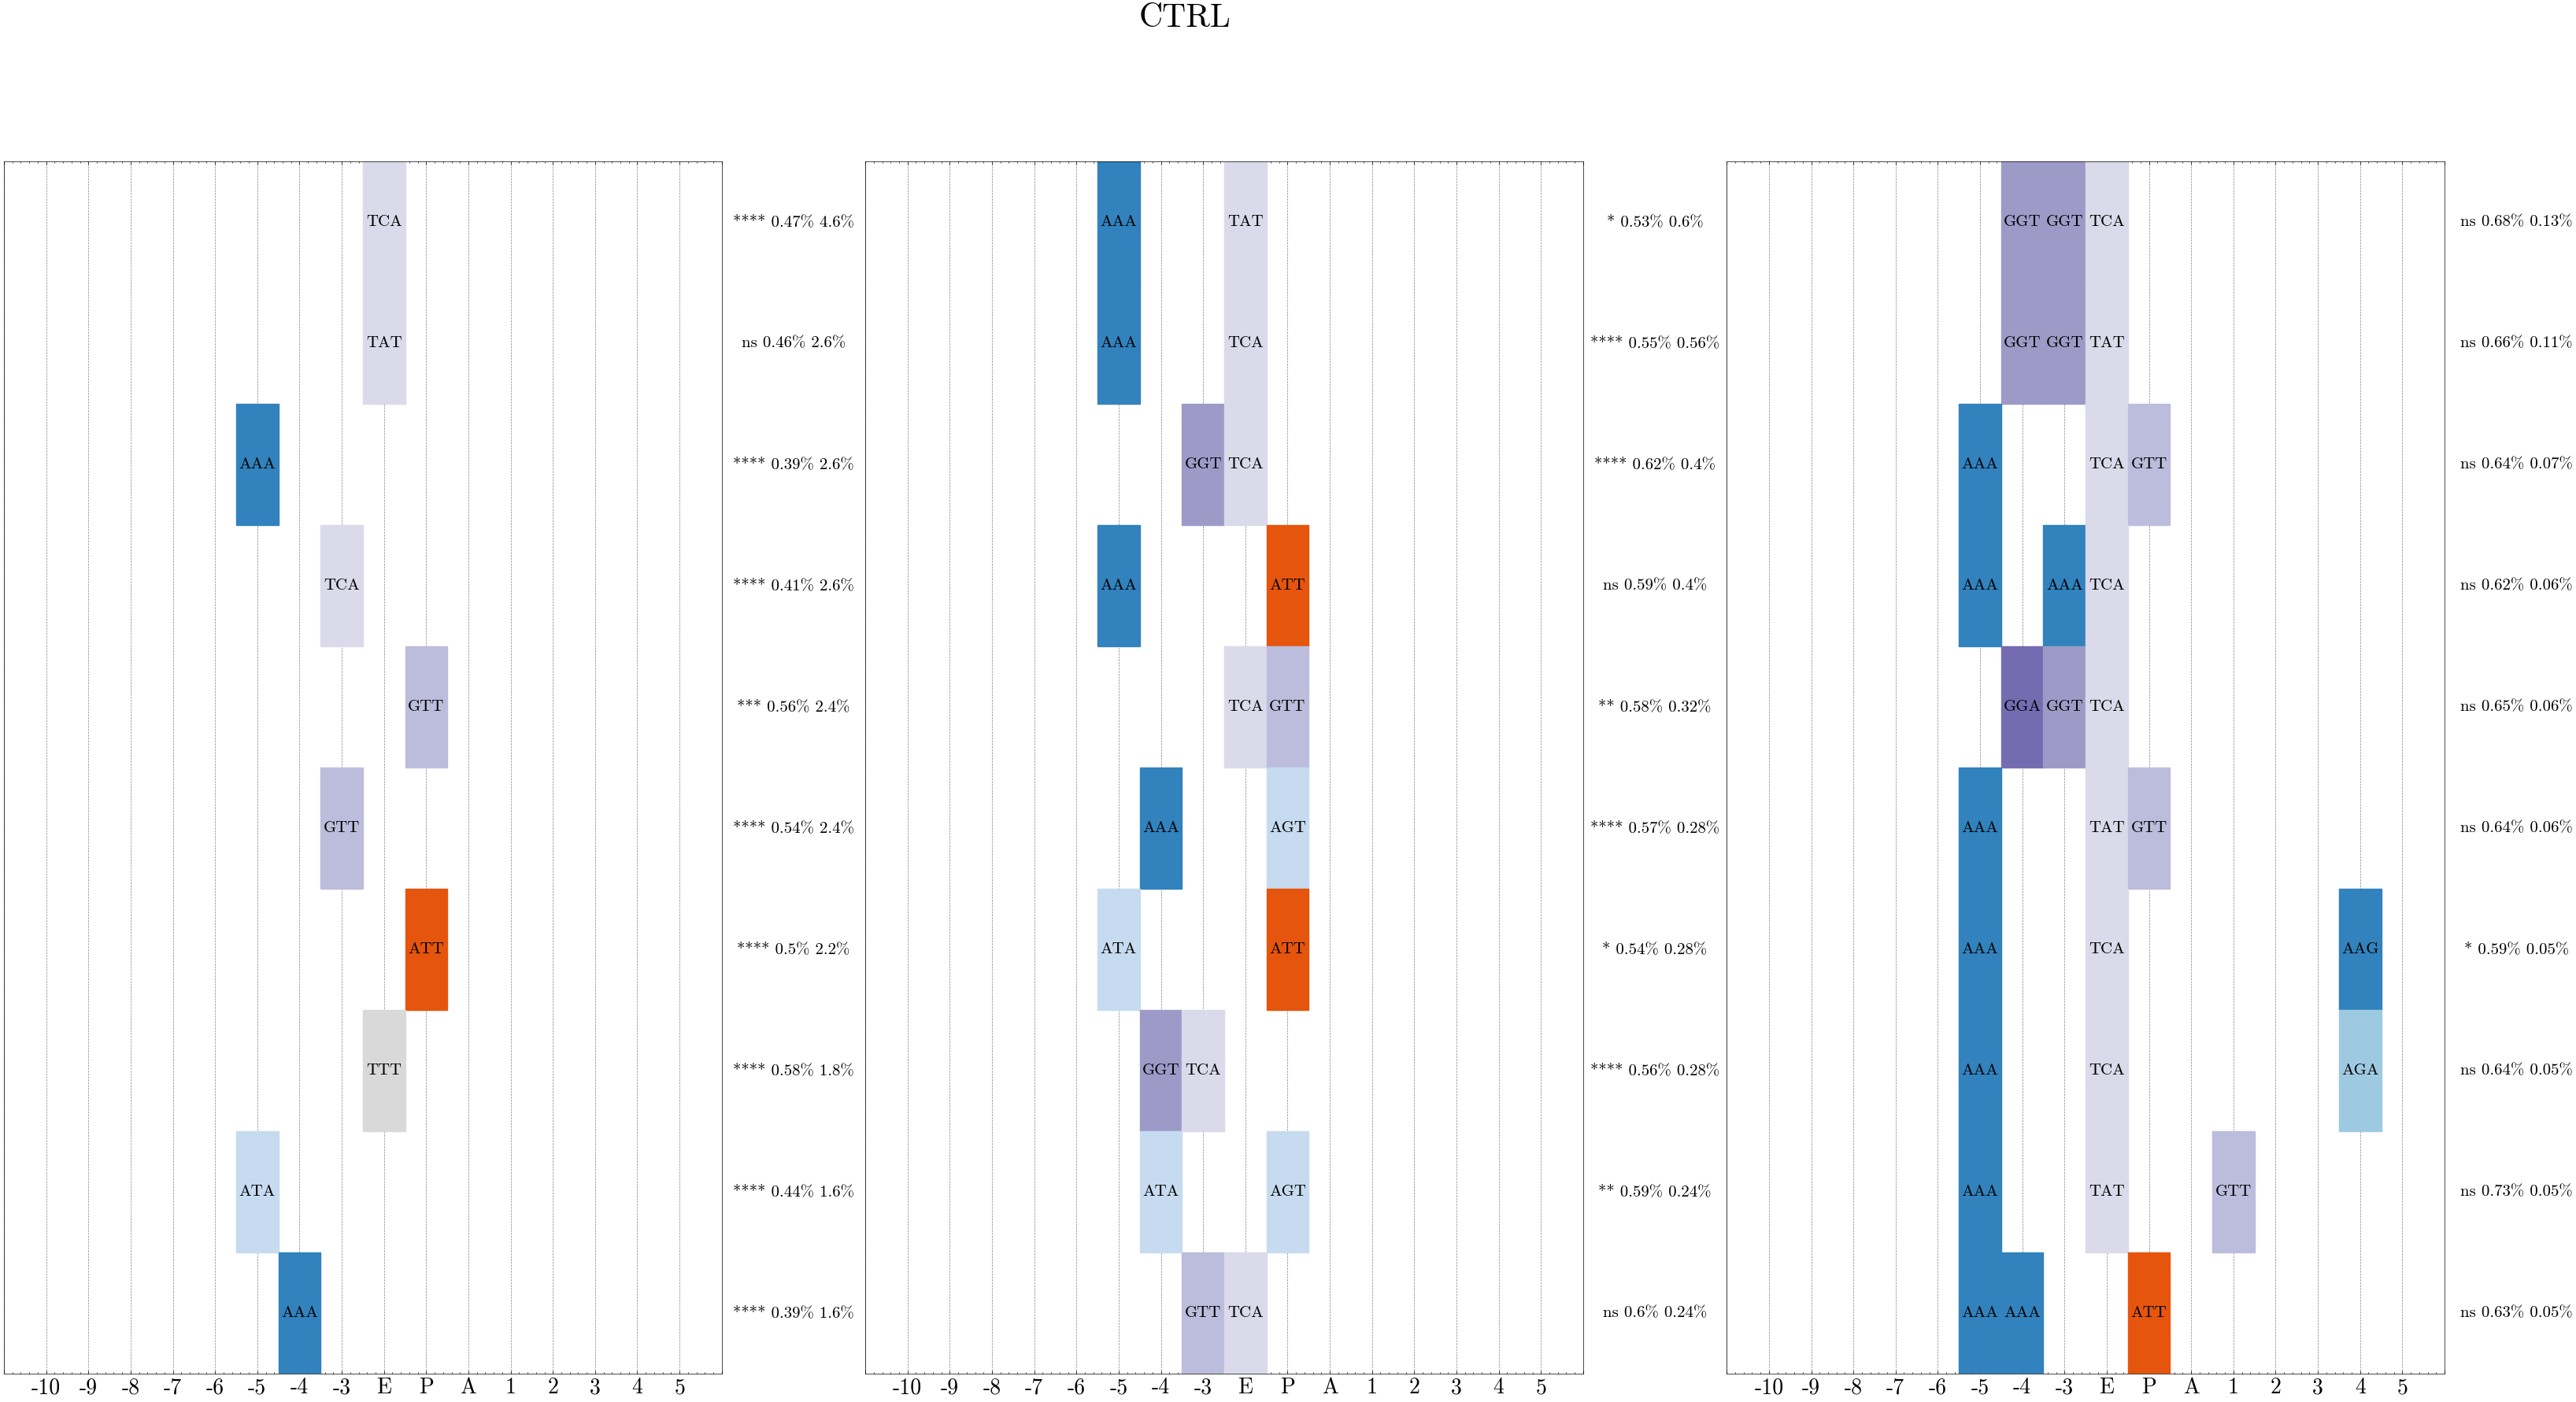

[0.0985960140824318, -0.10640303790569305, 0.086921326816082, 0.08399812132120132, -0.039840176701545715, 0.0372161902487278, -0.12963834404945374, -0.04383433982729912, 0.11335553973913193, 0.08034013956785202, -0.046048570424318314, 0.012850670143961906, -0.008959552273154259, 0.005045395344495773, -0.054587576538324356, 0.210788294672966, -0.013628615066409111, -0.018690969794988632, -0.023194940760731697, 0.0834721252322197, -0.13773256540298462, -0.031042657792568207, 0.01202026754617691, -0.04364932328462601, -0.1085960865020752, 0.09759800881147385, -0.008200390264391899, -0.052347198128700256, -0.12066615372896194, 0.030298734083771706, 0.04208362102508545, -0.09172124415636063, -0.02678212895989418, 0.03150114789605141, -0.030085396021604538, -0.11370859295129776, -0.0037240502424538136, 0.056230783462524414, 0.0630364790558815, -0.05228691175580025, 0.13222475349903107, -0.08016087859869003, -0.07620563358068466, 0.03588053584098816, -0.02831409126520157, -0.02863018959760666

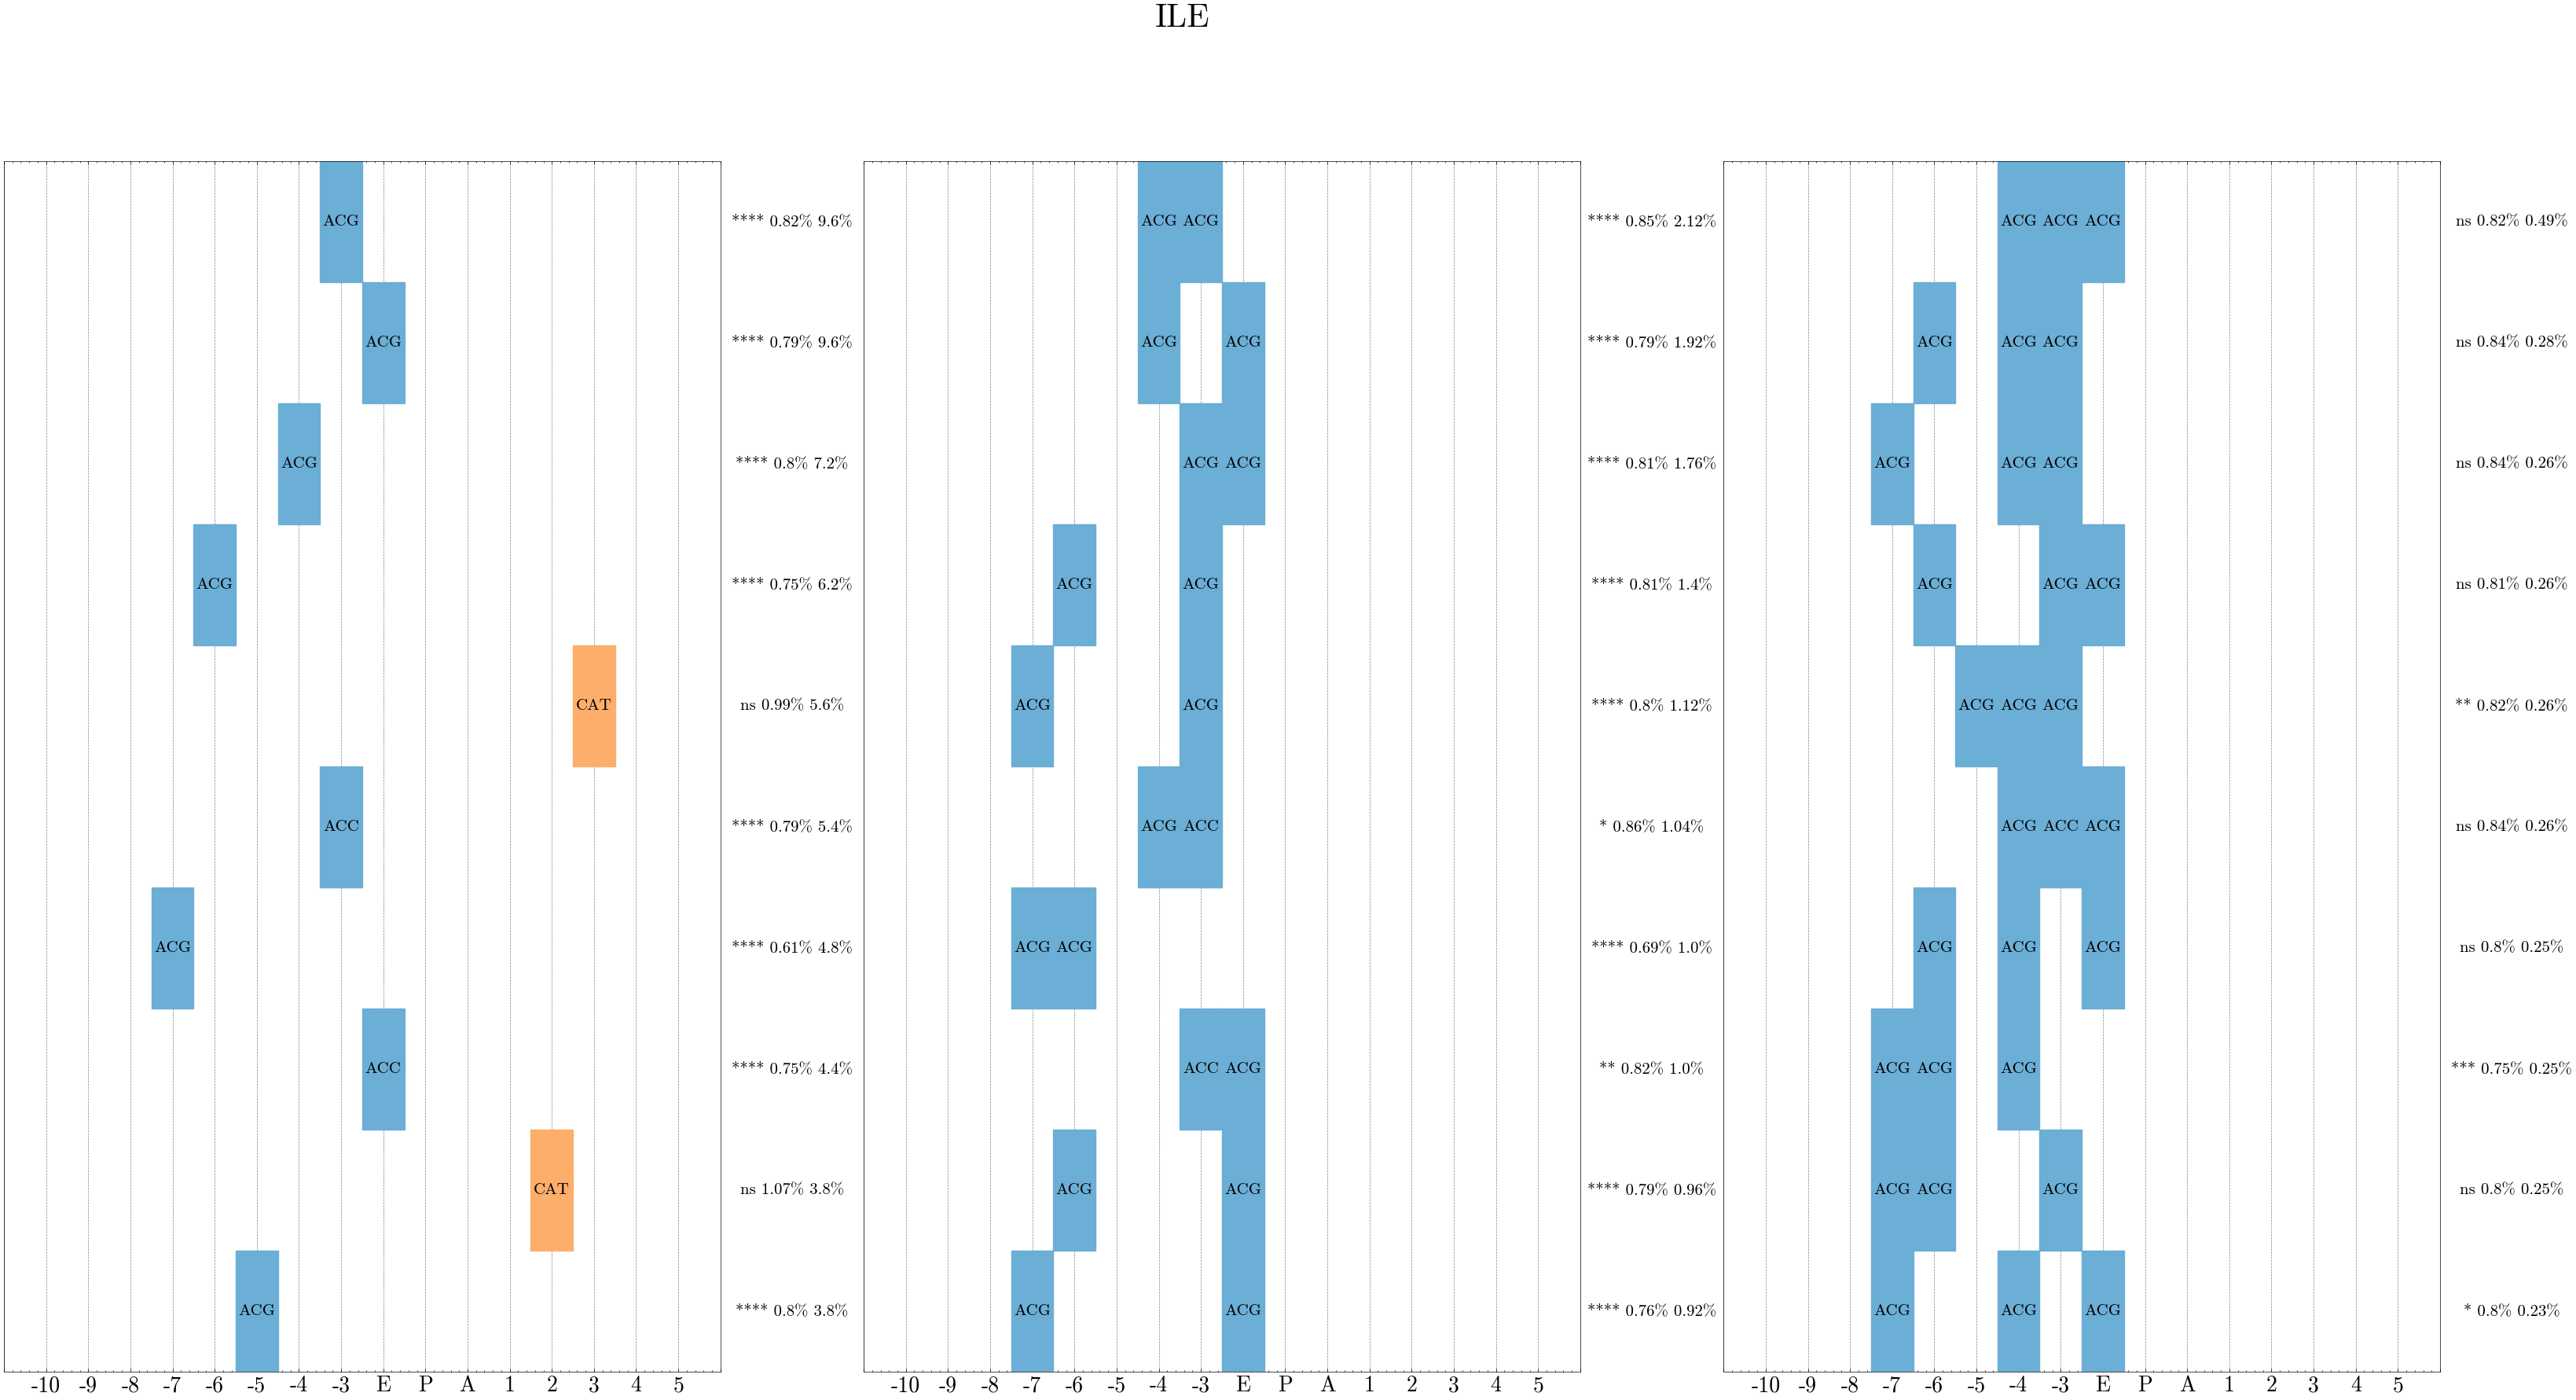

[0.008553546853363514, 0.06560838222503662, 0.07456956803798676, 0.06333281844854355, 0.033274319022893906, -0.05134202167391777, 0.021972104907035828, 0.03769684210419655, 0.07637491822242737, -0.06353217363357544, 0.025896668434143066, 0.011580223217606544, 0.01108870655298233, -0.016602223739027977, 0.03815009072422981, -0.022257905453443527, 0.08282618969678879, 0.04325748607516289, 0.09870458394289017, -0.02990226075053215, -0.050118401646614075, 0.012181141413748264, 0.02578909695148468, 0.018375301733613014, -0.009044885635375977, 0.02067486383020878, 0.013579918071627617, -0.059977512806653976, 0.06991513818502426, -0.1571062058210373, -0.049879878759384155, 0.025943385437130928, 0.015343144536018372, 0.010387851856648922, 0.007236375007778406, 0.08211956173181534, -0.015847504138946533, 0.0025950558483600616, 0.0342748798429966, -0.030589133501052856, -0.0002790861763060093, 0.05830187350511551, 0.08749625831842422, 0.018491821363568306, 0.04785043001174927, 0.0859673097729682

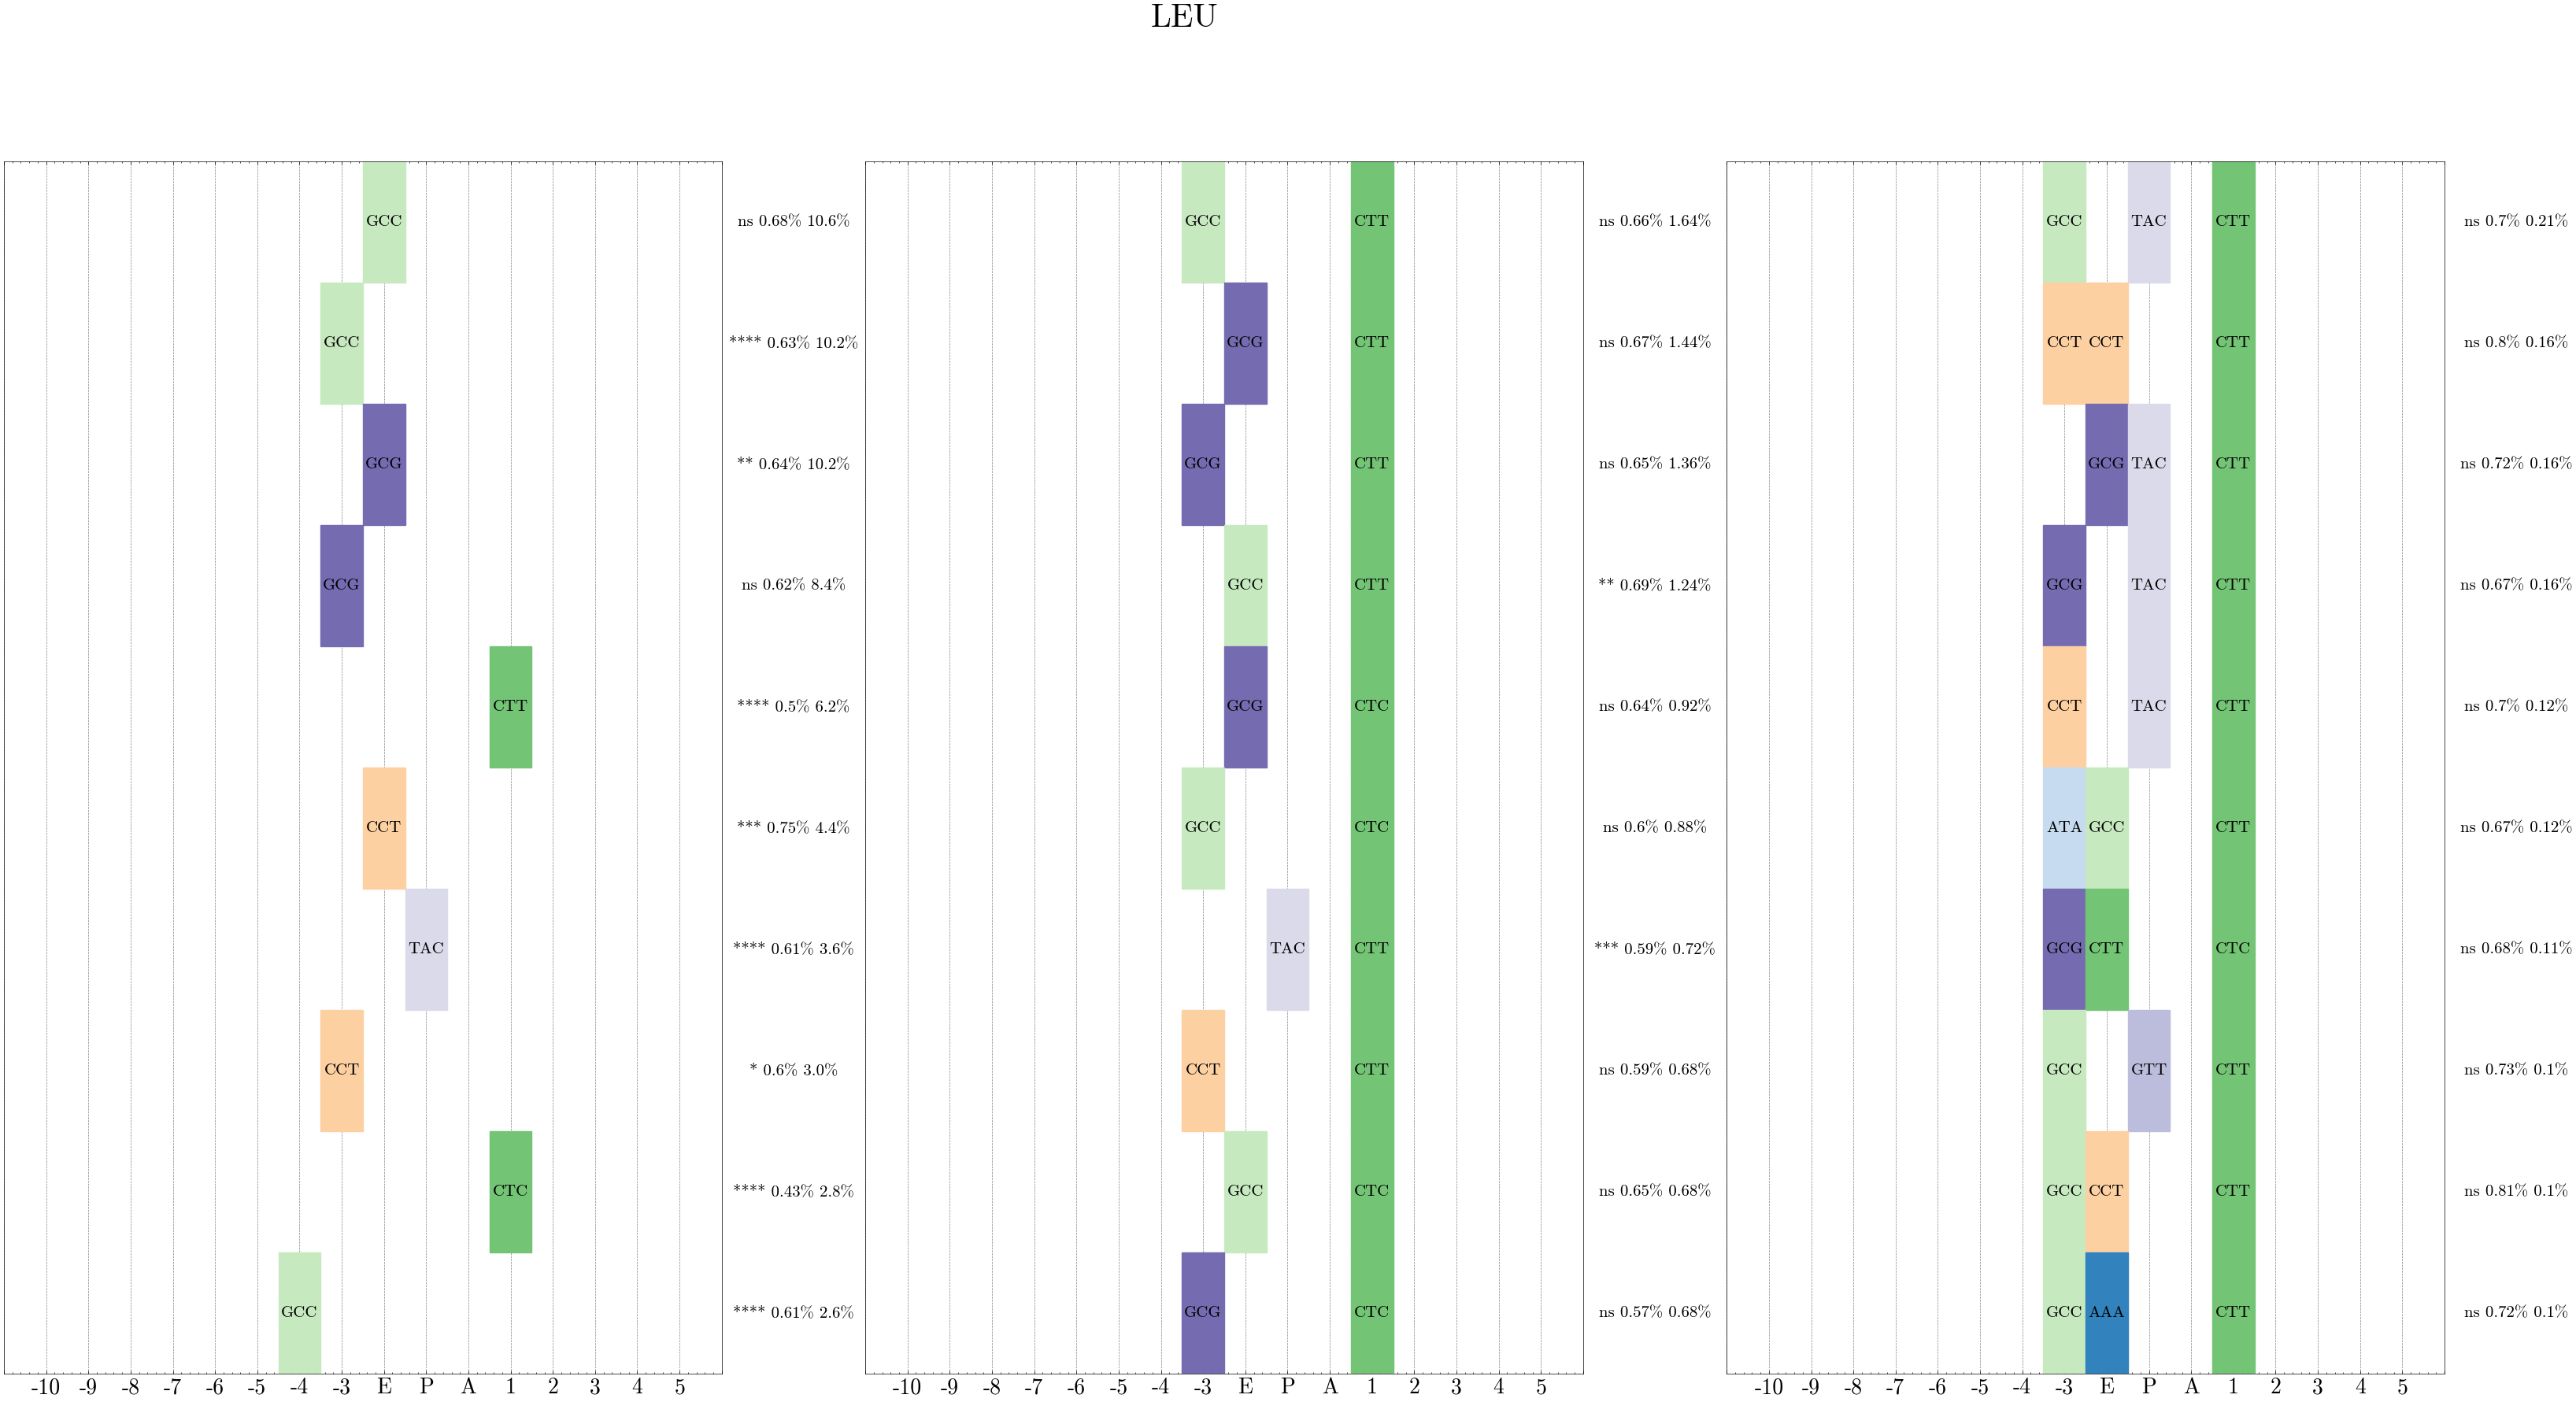

[-0.047710590064525604, -0.052608128637075424, 0.10637200623750687, 0.0681564211845398, -0.03497368097305298, -0.07391291111707687, -0.012531831860542297, 0.07386191934347153, 0.02022286131978035, -0.08087752014398575, -0.12597131729125977, -0.08639873564243317, -0.04694816842675209, -0.004772927146404982, -0.009158780798316002, -0.07141145318746567, -0.4459981918334961, -0.022701570764183998, 0.07782222330570221, 0.029771126806735992, 0.03374926373362541, 0.10282231122255325, -0.007789731491357088, 0.12565991282463074, -0.05173754319548607, -0.0577431283891201, 0.11068139225244522, -0.09330742806196213, -0.03829466179013252, 0.026937521994113922, -0.06729521602392197, -0.04331997036933899, 0.05143509432673454, 0.09605299681425095, 0.05495990440249443, -0.051071349531412125, -0.01202700287103653, -0.00957408919930458, -0.06889543682336807, -0.011481499299407005, -0.0008685877546668053, -0.17078633606433868, 0.0019231182523071766, -0.005358399357646704, 0.2263815701007843, 0.03314362093

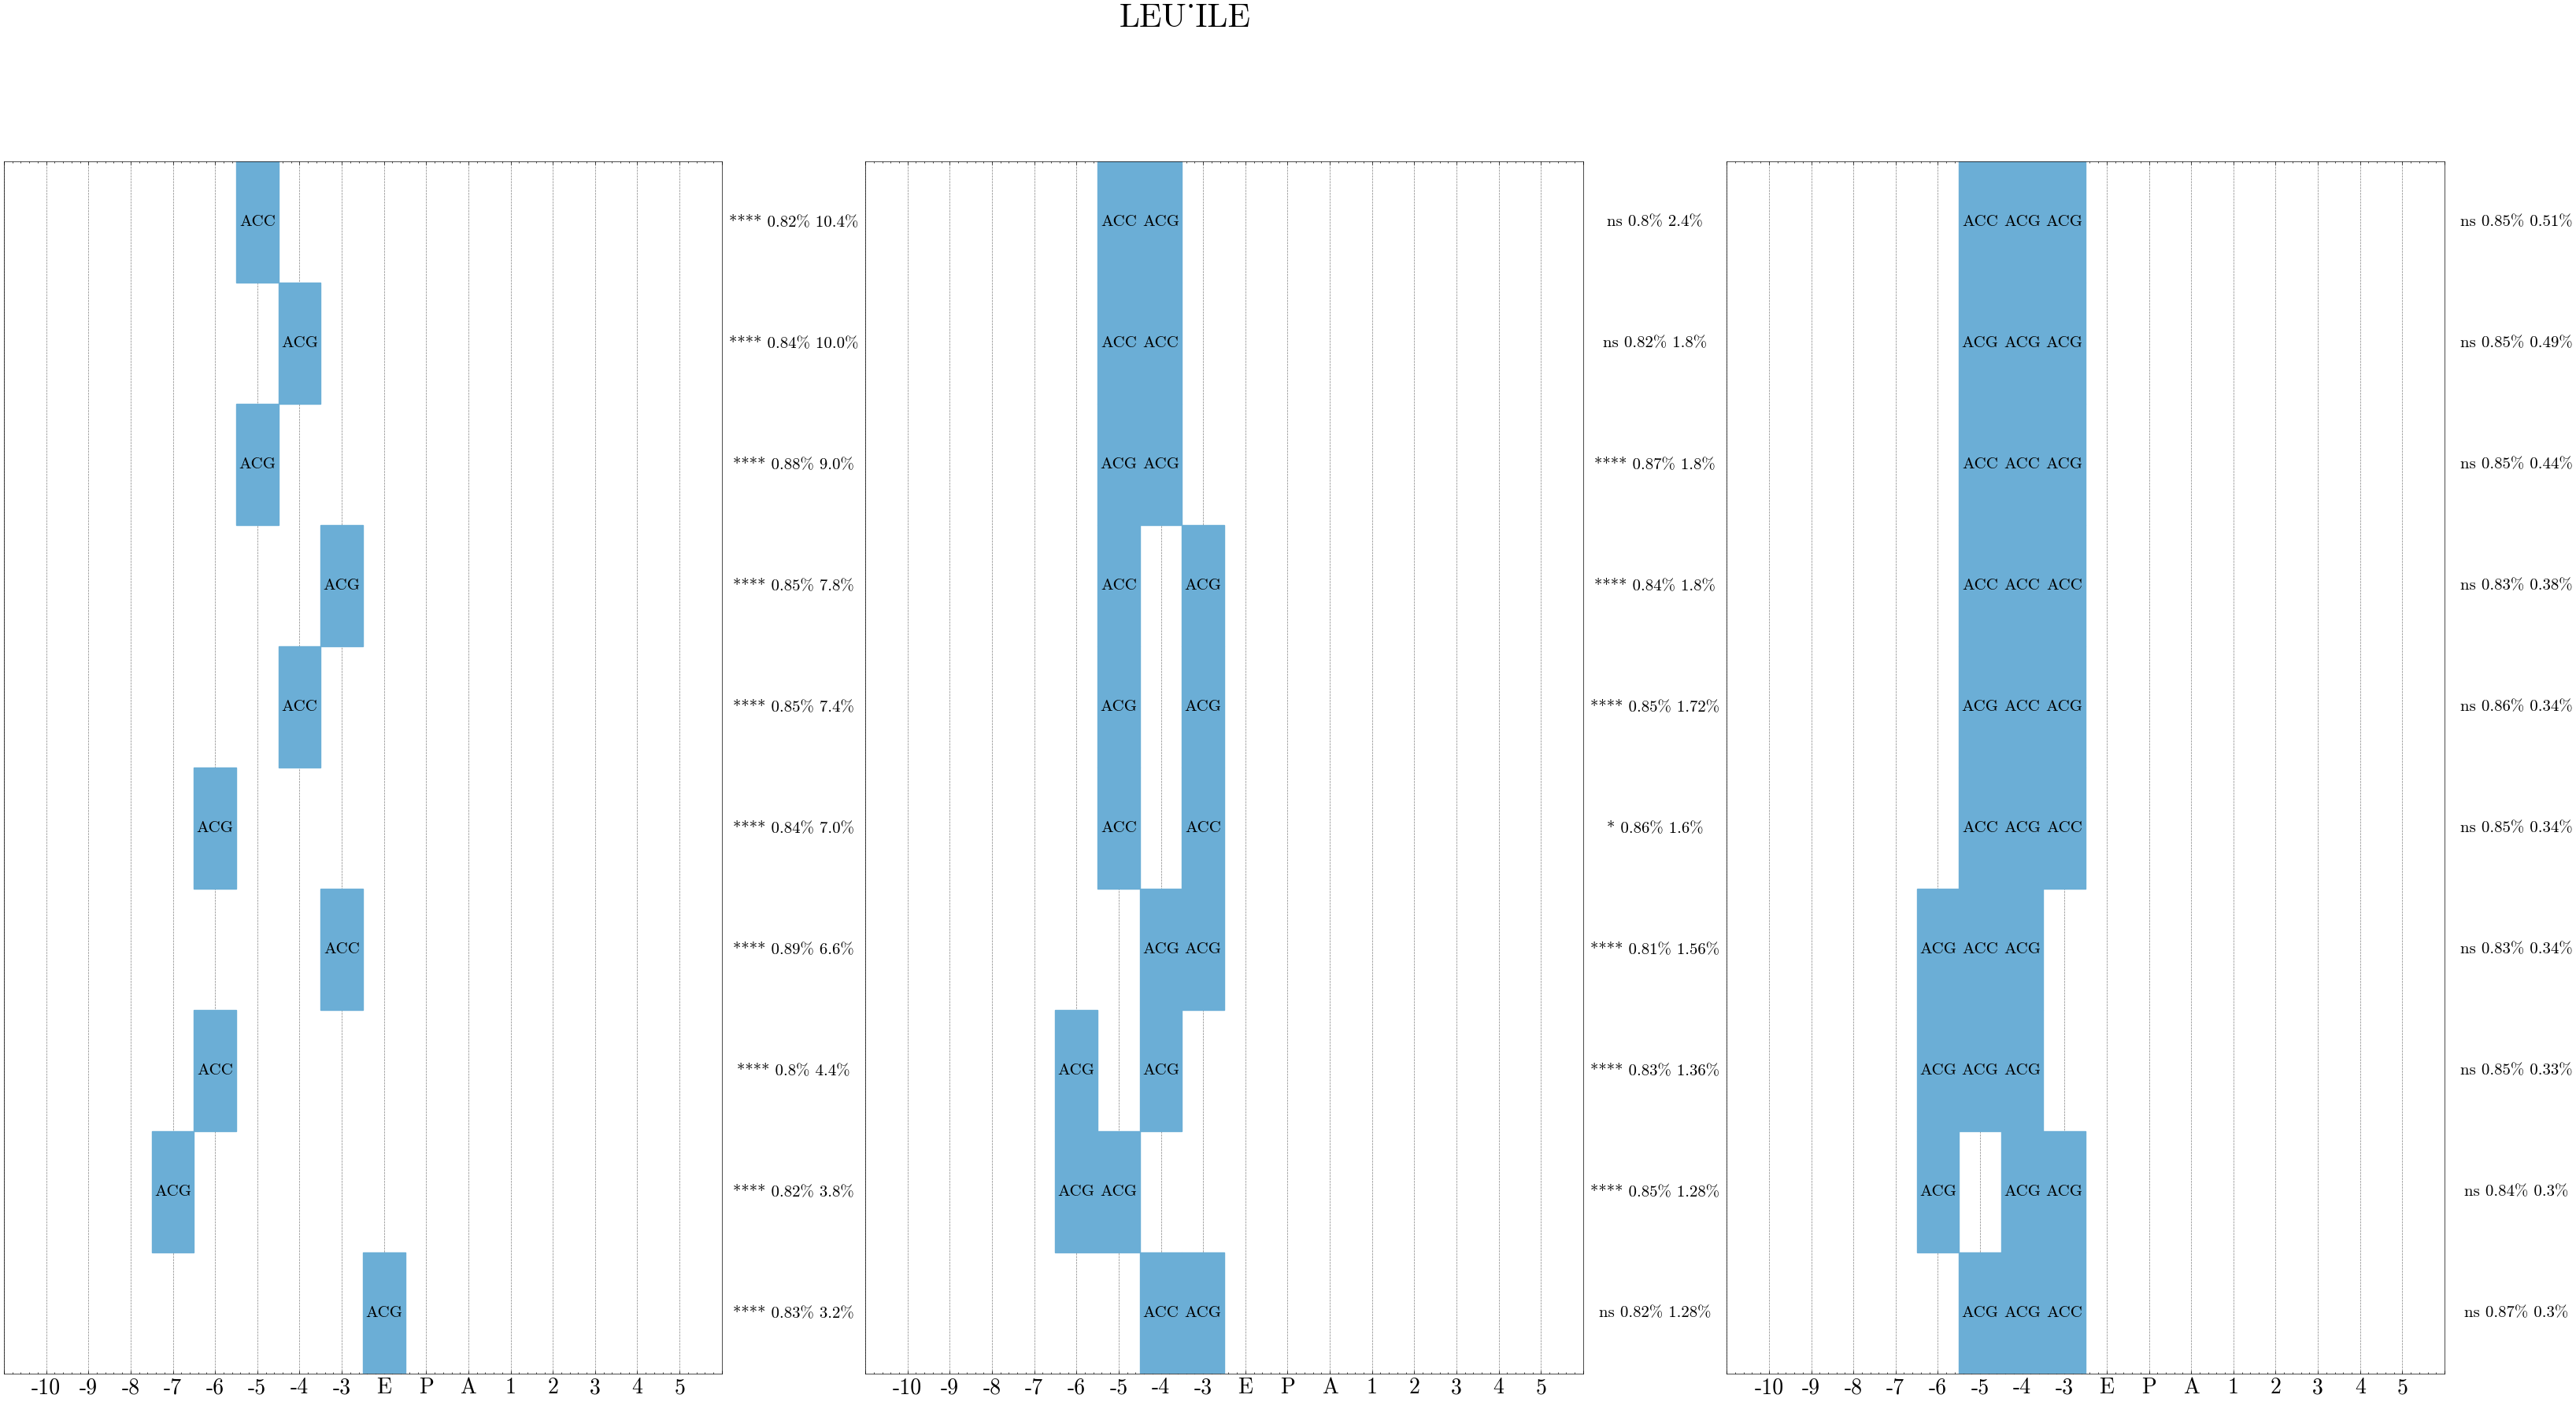

[-0.048978909850120544, -0.03640748932957649, -0.016055695712566376, -0.05815402790904045, -0.03196629136800766, -0.1171511635184288, 0.15442617237567902, 0.1700863093137741, -0.14491583406925201, 0.0611998625099659, -0.18274427950382233, -0.05017377808690071, 0.11798137426376343, 0.04723358526825905, -0.035270463675260544, 0.035819847136735916, -0.10631541907787323, -0.049930740147829056, -0.04144696518778801, -0.1265517771244049, -0.09518641978502274, -0.11673524230718613, -0.11032485216856003, -0.1432303935289383, 0.045789822936058044, 0.02268178015947342, 0.05837471783161163, -0.0707816332578659, -0.025018766522407532, 0.07428806275129318, -0.08506761491298676, 0.12607499957084656, 0.021333012729883194, -0.07413587719202042, -0.13211111724376678, -0.14810095727443695, -0.0375608429312706, 0.00975255947560072, -0.07115233689546585, -0.08457780629396439, -0.04774465039372444, -0.12958376109600067, -0.04782168194651604, -0.046076368540525436, -0.017183732241392136, -0.0169948749244213

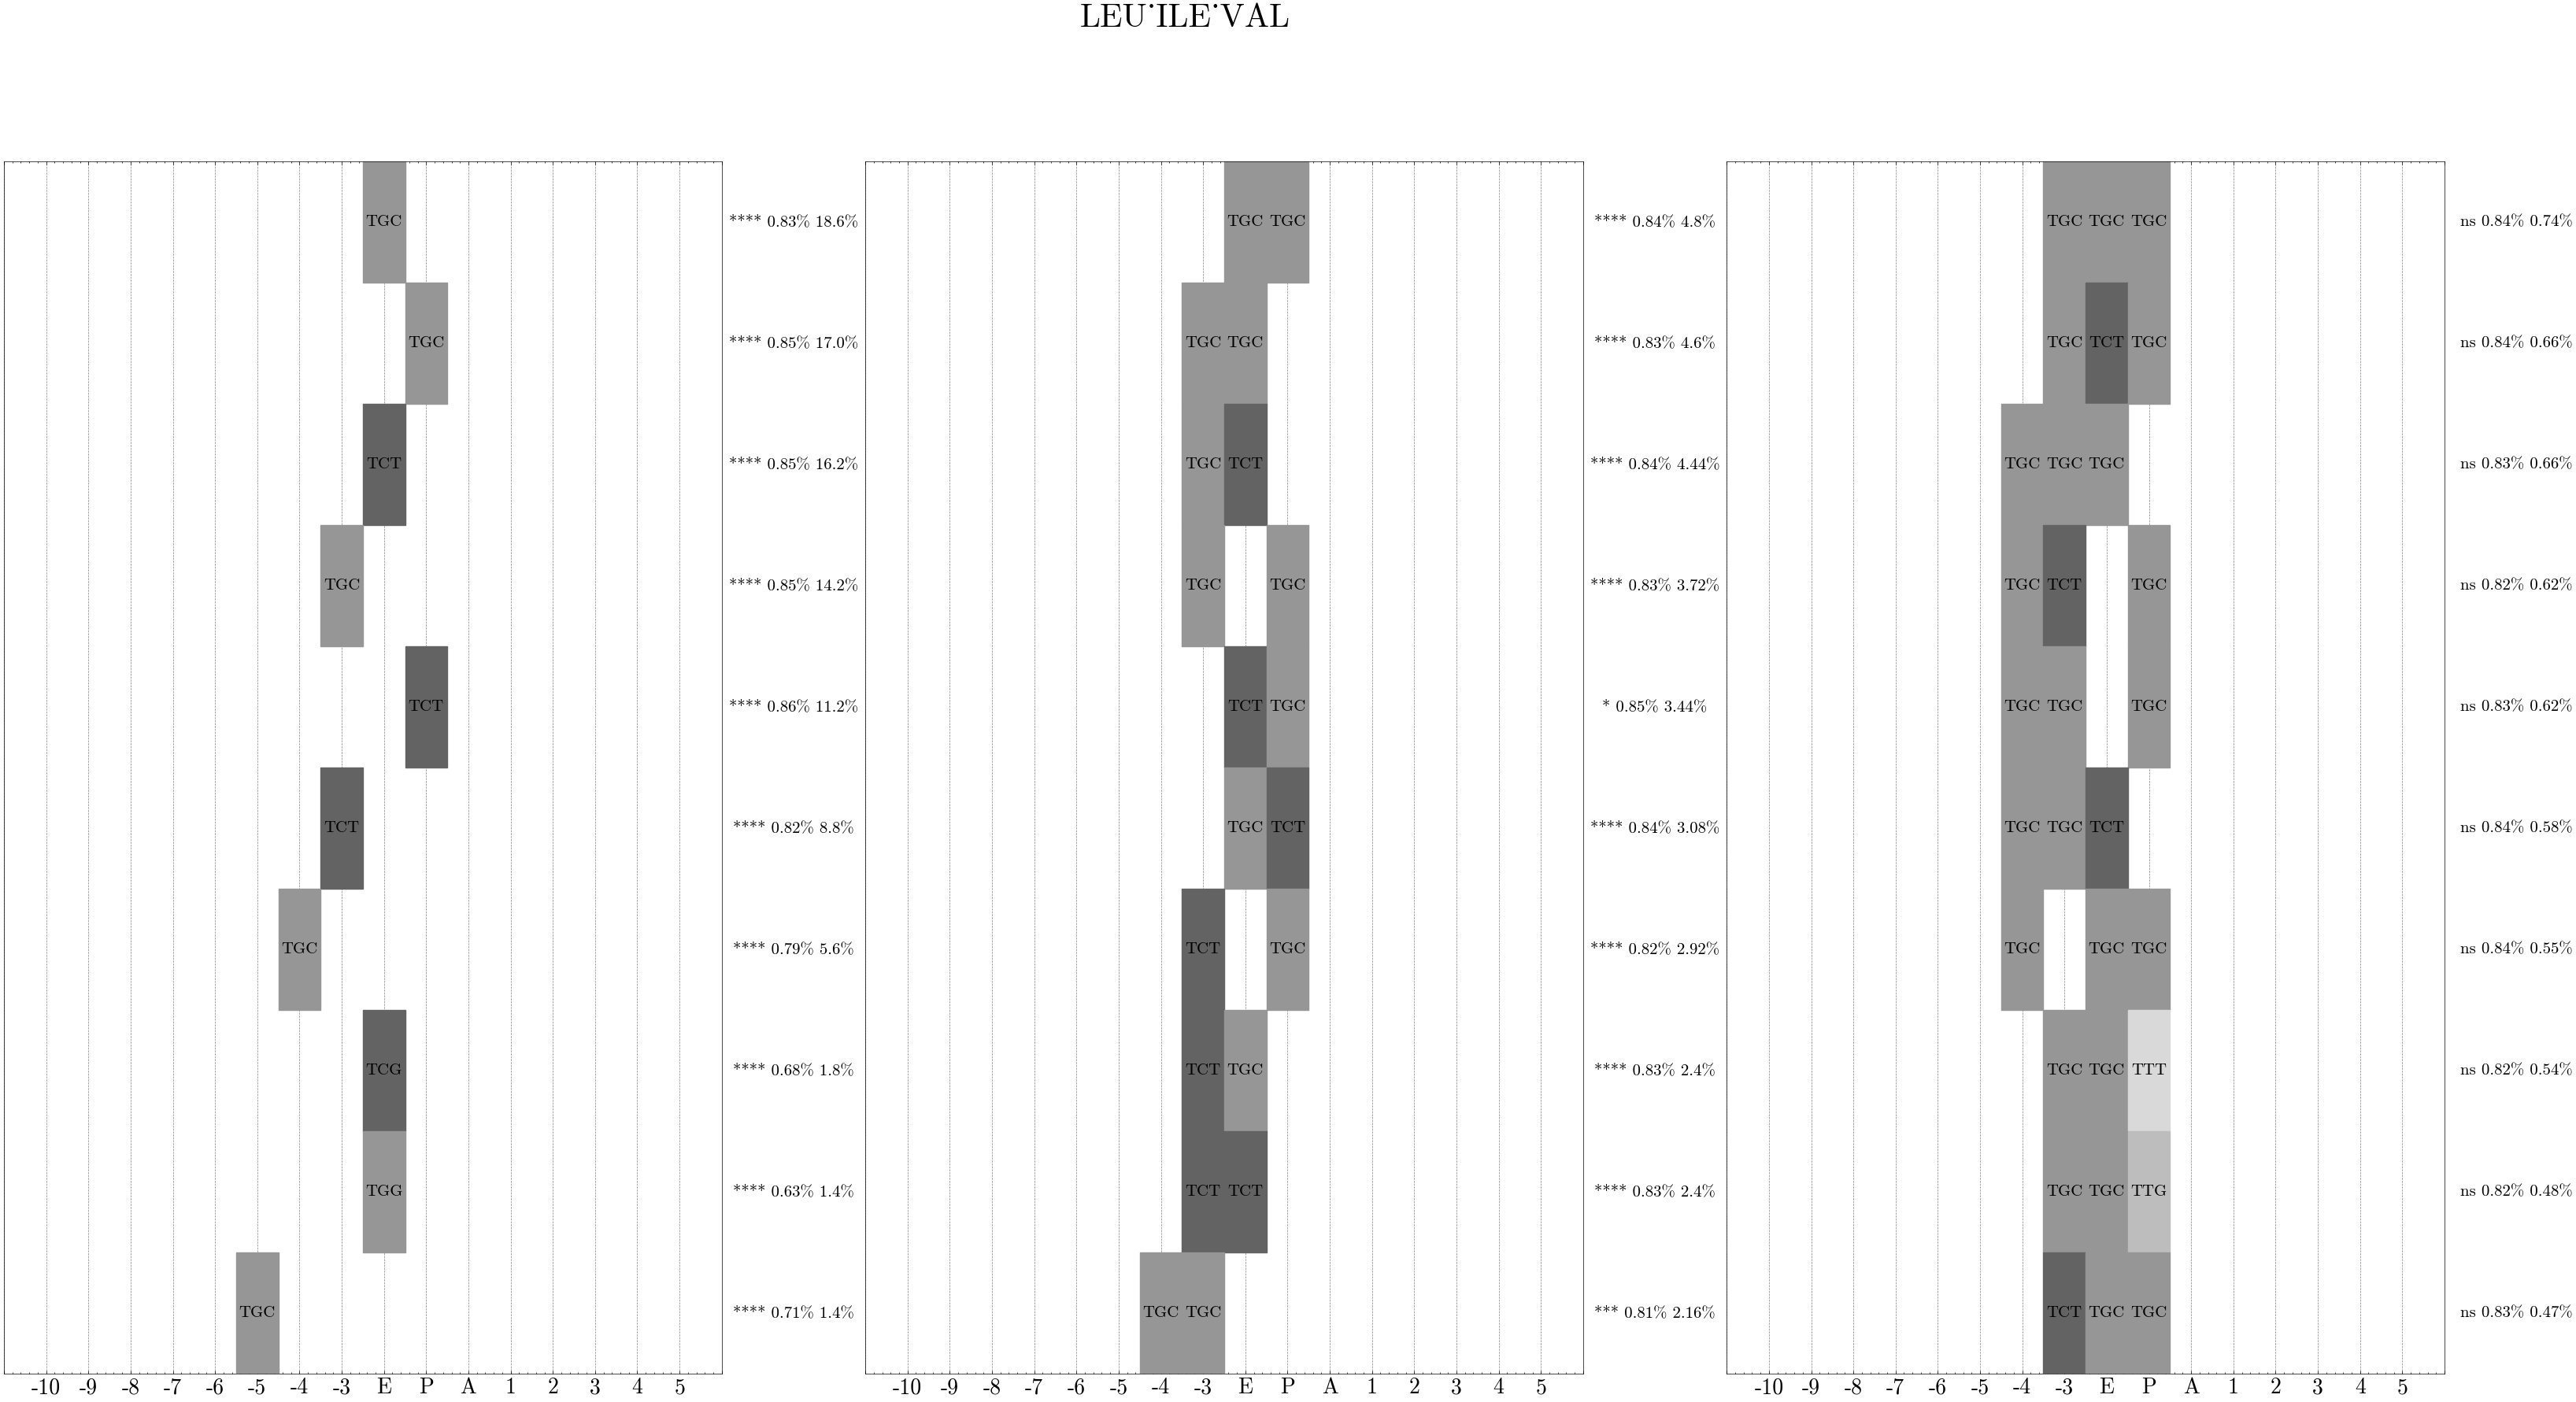

[0.24708180129528046, -0.03281044214963913, 0.12317360937595367, 0.137628972530365, -0.011246643960475922, -0.053086522966623306, -0.02510591223835945, -0.05506370589137077, -0.07282514125108719, 0.03731907159090042, -0.01362564042210579, 0.0006665163673460484, -0.09863169491291046, -0.031224925071001053, -0.0630127415060997, -0.09038052707910538, 0.010674044489860535, -0.05168125033378601, 0.034664805978536606, -0.050146039575338364, -0.0577925406396389, 0.030275024473667145, -0.0020080371759831905, 0.09614404290914536, 0.15250684320926666, -0.028688129037618637, 0.007584386505186558, -0.144319549202919, 0.04109642654657364, -0.1484726518392563, -0.13208724558353424, -0.06514132767915726, -0.01968216523528099, -0.06774663180112839, -0.049157749861478806, -0.05381147190928459, 0.04874076321721077, -0.07380156964063644, -0.008798424154520035, -0.024011077359318733, 0.02609478309750557, 0.19914735853672028, 0.00429184827953577, 0.14178992807865143, 0.020578254014253616, -0.01813937723636

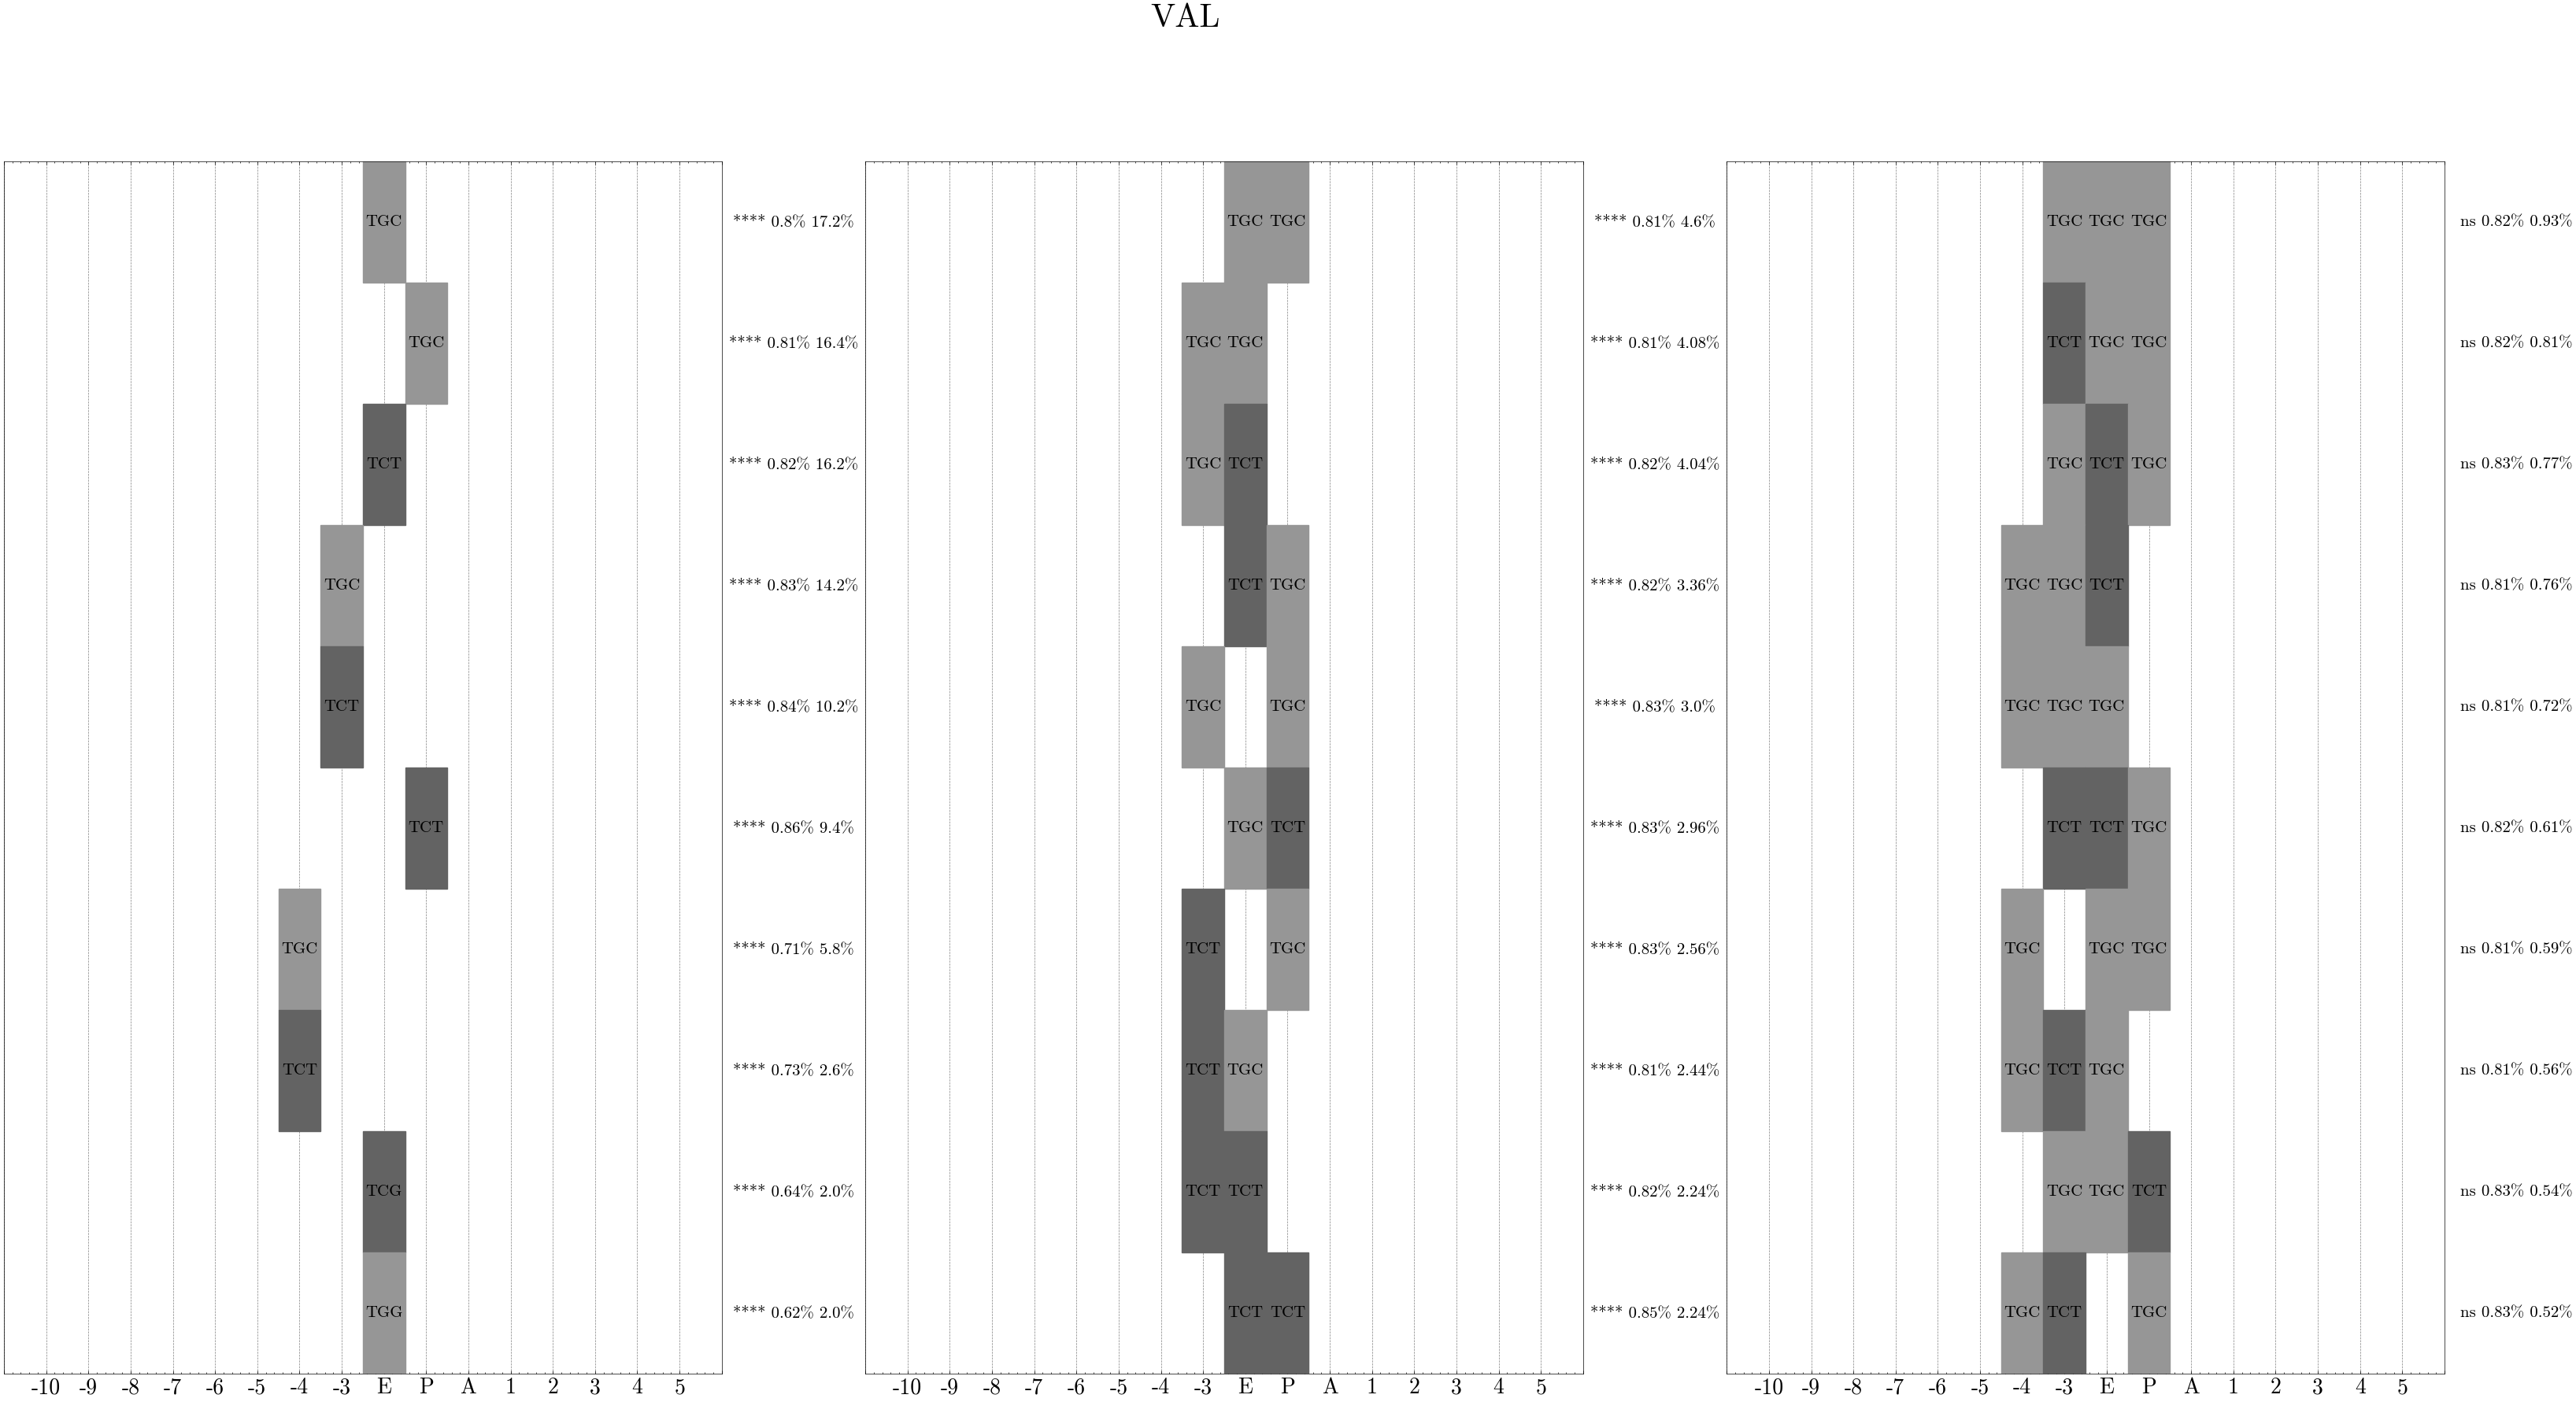

In [47]:
# gte 61 colors for the motifs
colors = plt.cm.tab20c(np.linspace(0, 1, 64))

with plt.style.context(['science','nature','grid','bright','no-latex']):
    for c in motifs_final_p:
        # make three subplots   
        fig, axs = plt.subplots(1, 3, figsize=(40, 20))
        # set the title
        fig.suptitle(c, fontsize=30)
        # for each subplot plot the 10 motifs 
        for plot in range(3):
            axs[plot].set_yticks([])
            # set x ticks
            axs[plot].set_xlim(-11, 6)
            axs[plot].set_xticks(range(-11, 7))
            axs[plot].set_xticklabels(['', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', ''], fontsize=20)
            motif_start = plot*10
            motifs_plot_keys = list(motifs_final_p[c].keys())[motif_start:motif_start+10]
            y_ax = 0.95
            for i in range(len(motifs_plot_keys)):
                # plot these motifs 
                m = [int(x) for x in motifs_plot_keys[i].split('_')[:-1]]
                for k in range(0, len(m), 2):
                    axs[plot].text(m[k], y_ax, id_to_codon[m[k+1]], ha='center', va='center', fontsize=15, color='black')
                    axs[plot].add_patch(plt.Rectangle((m[k]-0.5, y_ax-0.05), 1, 0.1, color=colors[m[k+1]], fill=True))

                # change the y-axis position for the next motif
                y_ax -= 0.1
                            
                # # plot the line between the two codons
                # ax.plot([pos1+0.5, pos2-0.5], [y_ax+0.1, y_ax+0.1], color='black', linewidth=0.5)

                # # plot the lines behind the codons and after the codons
                # ax.plot([-11, pos1-0.5], [y_ax+0.1, y_ax+0.1], color='black', linewidth=0.5)
                # ax.plot([pos2+0.5, 6], [y_ax+0.1, y_ax+0.1], color='black', linewidth=0.5)

                # add the p-value for the motif outside the figure to the right next to the motif
                try:
                    p_value_motif = float(motifs_final_p[c][motifs_plot_keys[i]][2])
                except:
                    p_value_motif = '-'
                if p_value_motif == '-':
                    p_text = 'ns'
                elif p_value_motif >= 0.05:
                    p_text = 'ns'
                elif p_value_motif < 1e-4:
                    p_text = '****'
                elif p_value_motif < 1e-3:
                    p_text = '***'
                elif p_value_motif < 1e-2:
                    p_text = '**'
                else:
                    p_text = '*'
                
                # axs[plot].text(6.5, y_ax+0.1, p_text, ha='center', va='center', fontsize=15, color='black')

                # add the percentage increase after the p-value
                # perc_inc_motif = str(round(np.abs(getPercIncrease(motifs_plot_keys[i], c)), 2)) + '%' 
                perc_inc_motif = str(round(getMAAPE(motifs_plot_keys[i], c), 2)) + '%'
                # axs[plot].text(7.8, y_ax+0.1, str(round(np.abs(perc_inc_motif), 2)) + '%', ha='center', va='center', fontsize=15, color='black')

                # add the frequency percentage after the percentage increase
                freq_perc_motif = str(round(getFreqPerc(motifs_plot_keys[i], c)*100, 2)) + '%'

                annot_text = p_text + ' ' + perc_inc_motif + ' ' + freq_perc_motif
                axs[plot].text(7.7, y_ax+0.1, annot_text, ha='center', va='center', fontsize=15, color='black')
                # axs[plot].text(9, y_ax+0.1, str(round(freq_perc_motif*100, 2)) + '%', ha='center', va='center', fontsize=15, color='black')
            
        plt.savefig('bms/plots/motifs_100_' + c + '.png', dpi=300)

        plt.show()
